In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(len(words), 'words')
print(max(len(word) for word in words), 'max word length')
print(words[:10])

32033 words
15 max word length
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {w: i+1 for i, w in enumerate(chars)}
stoi['.'] = 0
itos = {i: w for w, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size, 'characters')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27 characters


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8
device = 'cuda'

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        ctx = [0] * block_size
        for c in word + '.':
            X.append(ctx)
            Y.append(stoi[c])
            #print(''.join(itos[x] for x in ctx), '--->',c)
            ctx = ctx[1:] + [stoi[c]]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


n1 = int(len(words) * .8)
n2 = int(len(words) * .9)

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [6]:
for x, y in zip(Xtrain[:20], Ytrain[:20]):
    print(''.join(itos[x_.item()] for x_ in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


# Layer Types

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, device='cpu', bias=True):
        self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5
        self.b = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.b is None else [self.b])
    
class BatchNorm1d:
    def __init__(self, fan_in, eps=1e-5, momentum=0.1, device='cpu'):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(fan_in, device=device)
        self.beta = torch.zeros(fan_in, device=device)
        self.mean_running = torch.zeros(fan_in, device=device)
        self.var_running = torch.ones(fan_in, device=device)
        self.training = True

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            mean = x.mean(dim, keepdim=True)
            var = x.var(dim, keepdim=True)
        else:
            mean = self.mean_running
            var = self.var_running

        self.out = (x - mean) / (var + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.mean_running = self.momentum * self.mean_running + (1 - self.momentum) * mean
                self.var_running = self.momentum * self.var_running + (1 - self.momentum) * var

        return self.out 
        
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, vocab_size, embedding_size, device='cpu'):
        self.weight = torch.randn((vocab_size, embedding_size), device=device)

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# Network Setup

In [8]:
torch.manual_seed(42)

In [9]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd, device=device),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device=device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device=device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device=device), Tanh(),
    Linear(n_hidden, vocab_size, bias=False, device=device)
])

# make last layer less confident
with torch.no_grad():
  model.layers[-1].weight *= 0.1

print("Model Params:", sum(p.nelement() for p in model.parameters()))

for p in model.parameters():
    p.requires_grad = True

Model Params: 76552


In [10]:
for l in model.layers:
    # print class name and layer output shape
    print(l.__class__.__name__, l.out.shape if hasattr(l, 'out') else '')

Embedding 
FlattenConsecutive 
Linear 
BatchNorm1d 
Tanh 
FlattenConsecutive 
Linear 
BatchNorm1d 
Tanh 
FlattenConsecutive 
Linear 
BatchNorm1d 
Tanh 
Linear 


# Training

In [11]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #-- backprop
    for p in model.parameters():
        p.grad = None
    loss.backward()

    #learning_rate = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    # if i >= 1:
    #     break

print(loss)

      0/ 200000: 3.2722
  10000/ 200000: 2.1023
  20000/ 200000: 2.0940
  30000/ 200000: 2.1045
  40000/ 200000: 1.8258
  50000/ 200000: 2.1681
  60000/ 200000: 1.9409
  70000/ 200000: 2.2880
  80000/ 200000: 1.4527
  90000/ 200000: 2.0657
 100000/ 200000: 1.9235
 110000/ 200000: 1.7749
 120000/ 200000: 2.0051
 130000/ 200000: 1.9197
 140000/ 200000: 1.7978
 150000/ 200000: 2.0751
 160000/ 200000: 1.7593
 170000/ 200000: 1.9993
 180000/ 200000: 1.9351
 190000/ 200000: 1.9820
tensor(1.6147, device='cuda:0', grad_fn=<NllLossBackward0>)


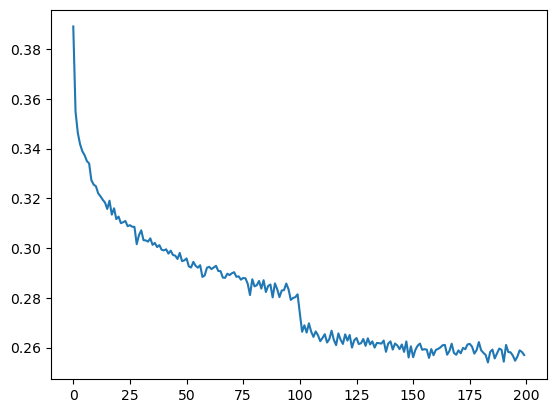

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [13]:
for layer in model.layers:
    layer.training = False

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss

loss_train = split_loss('train')
print('train', loss_train.item())

loss_dev = split_loss('dev')
print('dev', loss_dev.item())

train 1.834971308708191
dev 2.0279219150543213


## Perf log

- original (3 context, 10 emb, 200 hidden, 12k params): train 2.0956, dev 2.1383
- context 3->8: train 1.9788, dev 2.0832
- wavenet (10 emb, 200 hidden, 170k params): train 1.7997959852218628, dev 2.0326521396636963
- 24 emb, 128 hidden, 76k params: train 1.834971308708191, dev 2.0279219150543213

# Sample from model

In [23]:
samples = []
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net

      logits = model(torch.tensor([context]))
      # prediction
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    samples.append(''.join(itos[i] for i in out)) # decode and print the generated word
print(samples)

# append samples to file with new line spacing added: samples.txt
with open('samples.txt', 'a') as f:
    # seek to the end of the file
    f.seek(0, 2)
    f.write(''.join(samples))
            

['kyrie.', 'treyden.', 'hergt.', 'harven.', 'rileigh.', 'janessa.', 'gattleigh.', 'marif.', 'kopher.', 'christianna.', 'leiella.', 'garleny.', 'cason.', 'senna.', 'jezson.', 'johana.', 'adonath.', 'ryzan.', 'kiari.', 'elyssa.']


In [24]:
import re

def add_newlines(text):
    pattern = r'(?<!\n)\.(?!$|\n)'
    repl = '.\n'
    return re.sub(pattern, repl, text)

# Open the file for reading
with open('samples.txt', 'r') as f:
    # Read the contents of the file
    text = f.read()

# Add new lines after periods
formatted_text = add_newlines(text)

# Open the file for writing and write the formatted text
with open('samples.txt', 'w') as f:
    f.write(formatted_text)
                        